# CS 282
### Programming Assignment 1
#### Item 7

Jan Lendl R. Uy

2019-00312

#### Sytem Specifications
- macOS Sequoia 15.0.1
- Macbook Air M1 (ARM), 8-Core CPU and 8-Core GPU

In [17]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def read_images(base_names):
    """Read multiple cameraman images"""
    images = []
    for name in base_names:
        img = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
        else:
            print(f"Error reading {name}")
    return images

In [20]:
def compute_fourier_spectrum(image):
    """
    Compute and return magnitude and phase spectrum using OpenCV functions
    """
    # Prepare the image for DFT
    # Optimal size for DFT is size with only prime factors 2, 3, and 5
    rows, cols = image.shape
    optimal_rows = cv2.getOptimalDFTSize(rows)
    optimal_cols = cv2.getOptimalDFTSize(cols)
    
    # Create padded image
    padded = cv2.copyMakeBorder(image, 0, optimal_rows - rows, 0, optimal_cols - cols, 
                              cv2.BORDER_CONSTANT, value=0)
    
    # Create complex image for DFT
    complex_img = np.zeros((padded.shape[0], padded.shape[1], 2), dtype=np.float32)
    complex_img[:, :, 0] = padded  # Real part
    
    # Perform DFT
    dft = cv2.dft(complex_img, flags=cv2.DFT_COMPLEX_OUTPUT)
    
    # Shift the zero frequency component to the center
    dft_shift = np.zeros_like(dft)
    rows, cols = padded.shape
    center_row, center_col = rows // 2, cols // 2
    
    dft_shift[0:center_row, 0:center_col, :] = dft[center_row:rows, center_col:cols, :]
    dft_shift[0:center_row, center_col:cols, :] = dft[center_row:rows, 0:center_col, :]
    dft_shift[center_row:rows, 0:center_col, :] = dft[0:center_row, center_col:cols, :]
    dft_shift[center_row:rows, center_col:cols, :] = dft[0:center_row, 0:center_col, :]
    
    # Calculate magnitude and phase using OpenCV functions
    real = dft_shift[:, :, 0]
    imaginary = dft_shift[:, :, 1]
    
    # Calculate magnitude
    magnitude = cv2.magnitude(real, imaginary)
    
    # Add small value to avoid log(0) and use OpenCV's log
    magnitude_plus_one = magnitude + 1
    log_magnitude = cv2.log(magnitude_plus_one)
    
    # Normalize for display
    magnitude_spectrum = cv2.normalize(log_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    # Calculate phase
    phase = cv2.phase(real, imaginary)
    
    # Normalize phase for display
    phase_spectrum = cv2.normalize(phase, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    return magnitude_spectrum, phase_spectrum


In [21]:
def display_fourier_analysis(images, titles):
    """
    Display original images with their Fourier magnitude and phase spectra
    """
    n_images = len(images)
    fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))
    
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (img, title) in enumerate(zip(images, titles)):
        # Compute Fourier spectra using OpenCV
        magnitude_spectrum, phase_spectrum = compute_fourier_spectrum(img)
        
        # Original image
        axes[idx, 0].imshow(img, cmap='gray')
        axes[idx, 0].set_title(f'{title}\nOriginal Image')
        axes[idx, 0].axis('off')
        
        # Magnitude spectrum
        axes[idx, 1].imshow(magnitude_spectrum, cmap='gray')
        axes[idx, 1].set_title('Magnitude Spectrum\n(log scale)')
        axes[idx, 1].axis('off')
        
        # Phase spectrum
        axes[idx, 2].imshow(phase_spectrum, cmap='gray')
        axes[idx, 2].set_title('Phase Spectrum')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


## Verify translation property

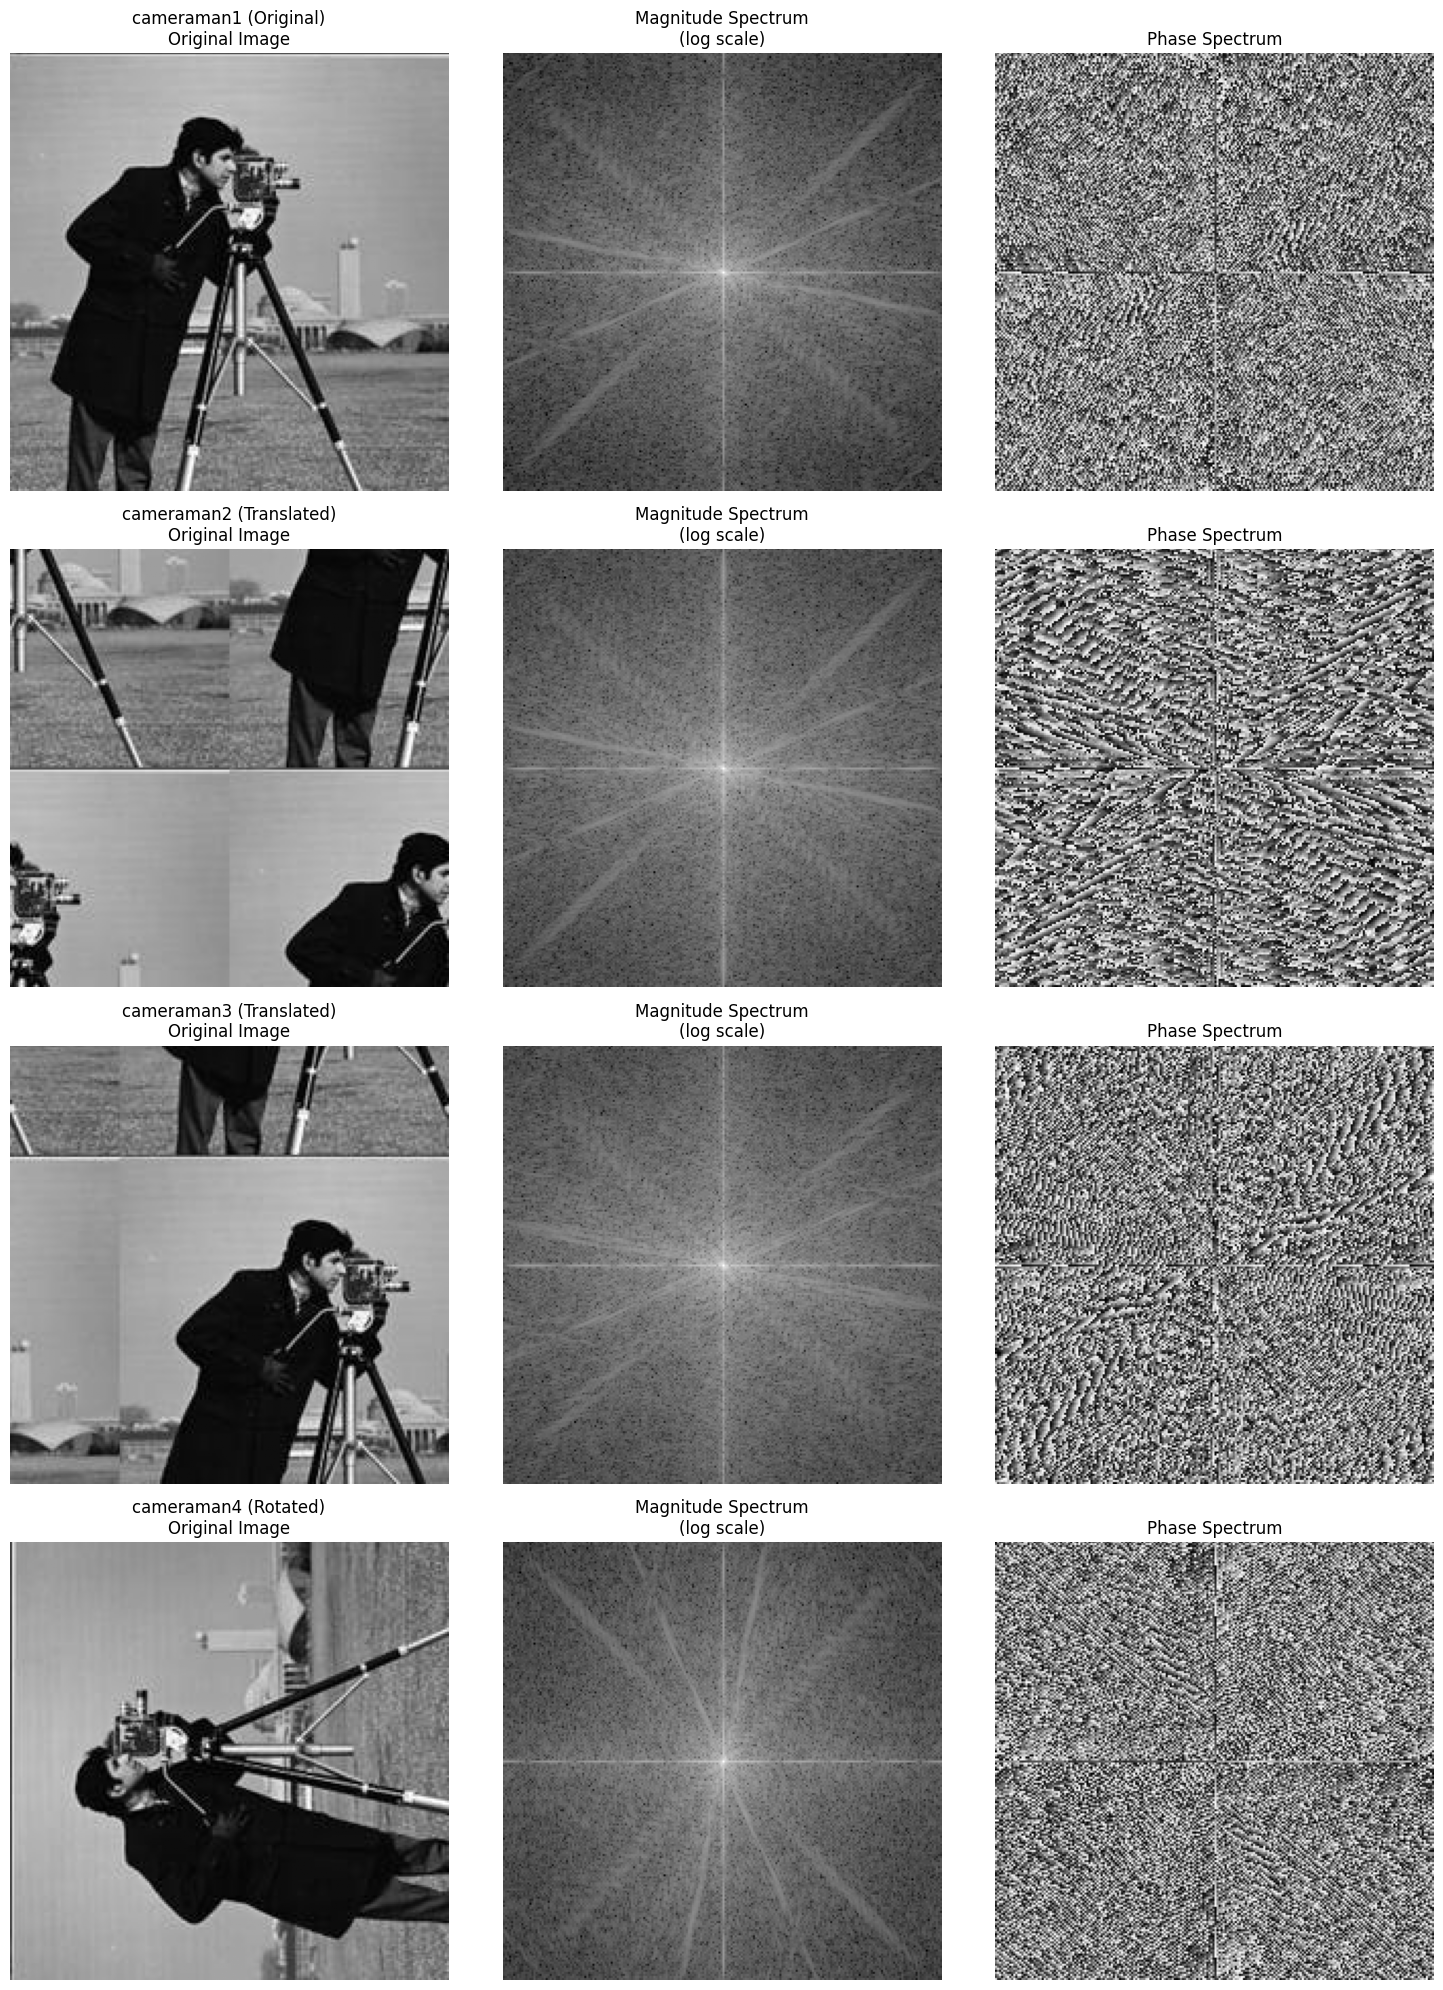

In [22]:
# Read images
images = read_images(
    [
        "images/cameraman1.jpg",
        "images/cameraman2.jpg", 
        "images/cameraman3.jpg",
        "images/cameraman4.jpg"
    ]
)

display_fourier_analysis(images, 
                        ['cameraman1 (Original)', 'cameraman2 (Translated)', 'cameraman3 (Translated)', 'cameraman4 (Rotated)'])

## Observations

Translation Property

Comparing the original image (i.e. cameraman1.jpg) with its translated versions (cameraman2.jpg and cameraman3.jpg), the Fourier transform confirmed two properties. First is that the magnitude spectra remain identical despite spatial translation. Second is that the phase spectra undergo phase shifts as an effect of translation. This is evidenced by the different patterns in the phase spectrum of each image.

Rotation Property

Comparing cameraman1.jpg with cameraman4.jpg (i.e. rotated 90-degrees counterclockwise) revealed that the magnitude and phase spectrum in the frequency domain rotated by exactly the same 90° angle counterclockwise.